# CE475 - Project
###### Full Name: Ozan Şahin
###### Student ID: 20190602036

In [279]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

In [280]:
raw_dataset = pd.read_csv('project_data.csv', delimiter=';')
dataset = raw_dataset.copy()

In [281]:
dataset.head()

,x1,x2,x3,x4,x5,x6,Y
0,1,37,12,65,-18,1,1.0
1,27,14,6,85,11,27,-24.0
2,34,13,14,63,-16,34,4092.0
3,5,18,24,83,-4,5,121.0
4,31,44,10,57,-7,31,2441.0


In [282]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      120 non-null    int64  
 1   x2      120 non-null    int64  
 2   x3      120 non-null    int64  
 3   x4      120 non-null    int64  
 4   x5      120 non-null    int64  
 5   x6      120 non-null    int64  
 6   Y       100 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 6.7 KB


In [283]:
pd.DataFrame(dataset.isna().sum()).T

,x1,x2,x3,x4,x5,x6,Y
0,0,0,0,0,0,0,20


I extracted the rows with null Y value from the dataset. I will use them as the test data.

In [284]:
test_data = dataset.tail(20)
dataset = dataset.drop(test_data.index)

In [285]:
test_data.head()

,x1,x2,x3,x4,x5,x6,Y
100,8,46,30,32,5,8,NaN
101,10,23,16,27,13,10,NaN
102,6,9,28,76,-20,6,NaN
103,11,31,3,46,-11,11,NaN
104,12,27,0,98,20,12,NaN


I can see that the train data has no null values now.

In [286]:
pd.DataFrame(dataset.isna().sum()).T

,x1,x2,x3,x4,x5,x6,Y
0,0,0,0,0,0,0,0


In [287]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      100 non-null    int64  
 1   x2      100 non-null    int64  
 2   x3      100 non-null    int64  
 3   x4      100 non-null    int64  
 4   x5      100 non-null    int64  
 5   x6      100 non-null    int64  
 6   Y       100 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 5.6 KB


In [288]:
dataset.describe().T[['min', 'max', 'mean']]

,min,max,mean
x1,0.0,40.0,19.29
x2,0.0,50.0,22.53
x3,0.0,35.0,16.68
x4,0.0,100.0,50.60
x5,-20.0,20.0,-1.44
x6,0.0,40.0,19.29
Y,-42.0,12402.0,1746.82


In [289]:
predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

I am looking for the correlation between the predictors.

In [290]:
dataset.corr()

,x1,x2,x3,x4,x5,x6,Y
x1,1.000000,-0.167880,-0.051437,-0.153805,0.091953,1.000000,0.300764
x2,-0.167880,1.000000,-0.047579,-0.072409,-0.191095,-0.167880,0.071139
x3,-0.051437,-0.047579,1.000000,0.106278,0.070286,-0.051437,0.280280
x4,-0.153805,-0.072409,0.106278,1.000000,-0.137413,-0.153805,0.122084
x5,0.091953,-0.191095,0.070286,-0.137413,1.000000,0.091953,-0.508310
x6,1.000000,-0.167880,-0.051437,-0.153805,0.091953,1.000000,0.300764
Y,0.300764,0.071139,0.280280,0.122084,-0.508310,0.300764,1.000000


I can see that there is a perfect positive correlation between x1 and x6. (correlation = 1)
I also plotted them to see the correlation better.

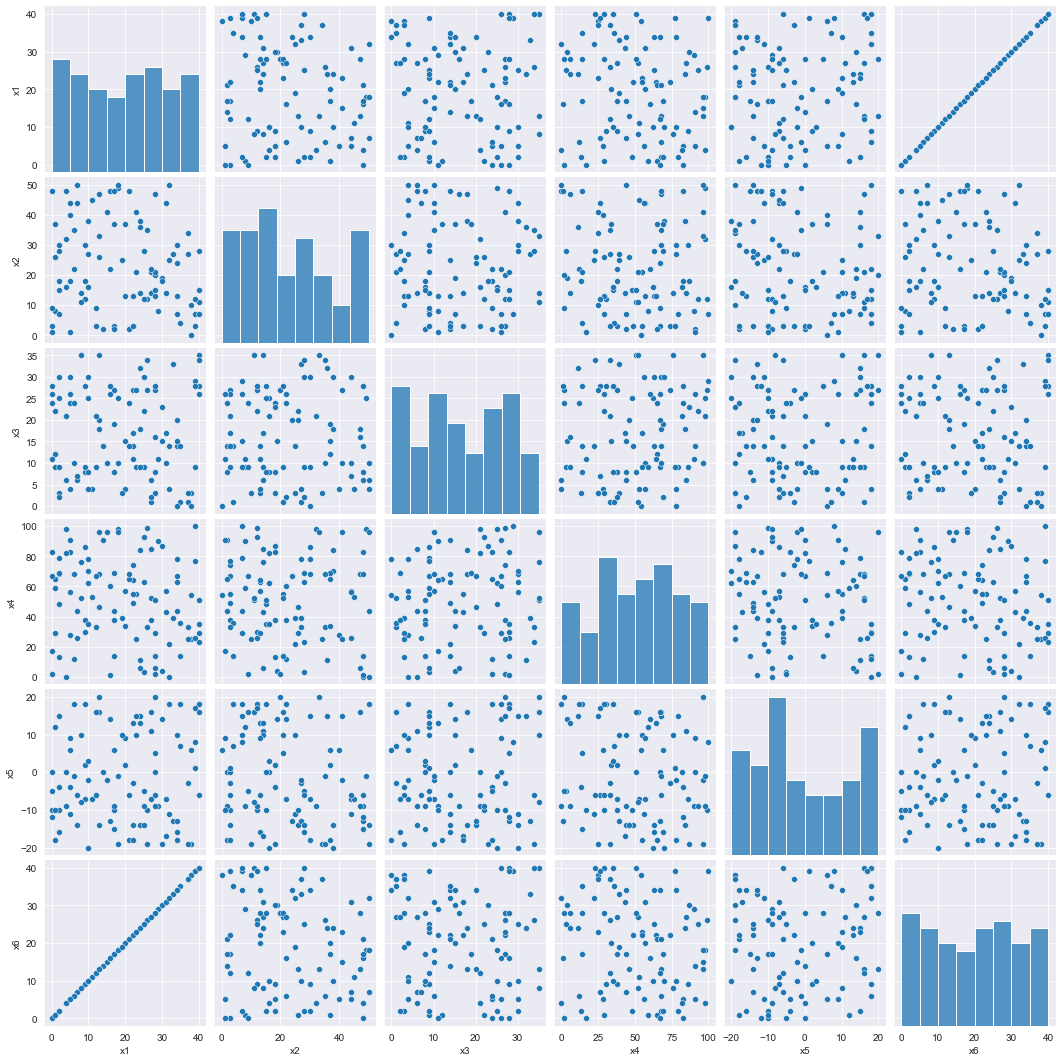

In [291]:
sns.pairplot(dataset[predictors])

I can see that the predictors x1 and x6 are identical. So I can drop one of them because it will not be useful.

In [292]:
dataset[['x1', 'x6']].T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
x1,1,27,34,5,31,9,39,37,2,38,...,5,28,13,21,25,10,22,23,19,27
x6,1,27,34,5,31,9,39,37,2,38,...,5,28,13,21,25,10,22,23,19,27


I chose to drop x6 instead of x1. (no special reason)

In [293]:
x6 = dataset['x6']
dataset.drop(columns=['x6'], inplace=True, axis=1)
test_data.drop(columns=['x6'], inplace=True, axis=1)
predictors.remove('x6')
predictors

['x1', 'x2', 'x3', 'x4', 'x5']

Default scoring functions inside the Sklearn Models gives negative results. That's why I used the make_scorer method to get positive scoring value. I chose the root-mean-squared error as the scoring function for all the algorithms.

### Linear Regression

In [223]:
def linear_regression(x, y, selected_predictors=None, cv=None):
    if selected_predictors is None:
        selected_predictors = predictors
    cval_score = np.sqrt(cross_val_score(estimator=LinearRegression(), X=x[selected_predictors], y=y, cv=cv,
                                       scoring=make_scorer(mean_squared_error)))
    cval_pred = cross_val_predict(estimator=LinearRegression(), X=x[selected_predictors], y=y, cv=cv)
    lr = LinearRegression()
    lr.fit(x, y)
    y_pred = lr.predict(test_data[predictors])

    return y_pred, cval_pred, cval_score

It is generally recommended to use k fold number of 5 or 10, but I wanted to see how they perform by myself.
After I used all of them, I decided to use 10-fold cross validation because, it gave the least error overall.

In [224]:
lin_reg_errors = pd.DataFrame()

for i in predictors:
    for j in range(2, 11):
        lin_pred, cv_predictions, rmse_score = linear_regression(x=dataset[predictors], y=dataset['Y'],
                                                             selected_predictors=[i], cv=j)
        lin_reg_errors.loc[f'cv={j}', i] = np.mean(rmse_score)

lin_reg_errors.sort_values(by=['x1', 'x2', 'x3', 'x4', 'x5'])

,x1,x2,x3,x4,x5
cv=10,2510.762374,2601.730101,2520.125624,2559.644270,2210.442221
cv=5,2558.030689,2650.673638,2567.476732,2609.239499,2284.881476
cv=8,2562.375277,2644.566197,2570.508544,2619.602333,2260.125125
cv=7,2564.418921,2644.426135,2565.533844,2622.558803,2325.943845
cv=6,2572.353430,2638.613572,2541.232811,2612.449963,2335.278749
cv=9,2573.878552,2623.768696,2555.428939,2602.035686,2268.621046
cv=4,2602.728839,2678.848674,2551.954197,2649.858128,2318.340801
cv=3,2630.974722,2704.350502,2614.822896,2653.089436,2351.179329
cv=2,2684.230889,2777.202359,2591.227069,2732.272184,2373.187196


In [225]:
_, cv_predictions, _ = linear_regression(x=dataset[predictors], y=dataset['Y'], cv=10)

I plotted the regression line for each of the predictors individually.

<AxesSubplot:xlabel='x5', ylabel='Y'>

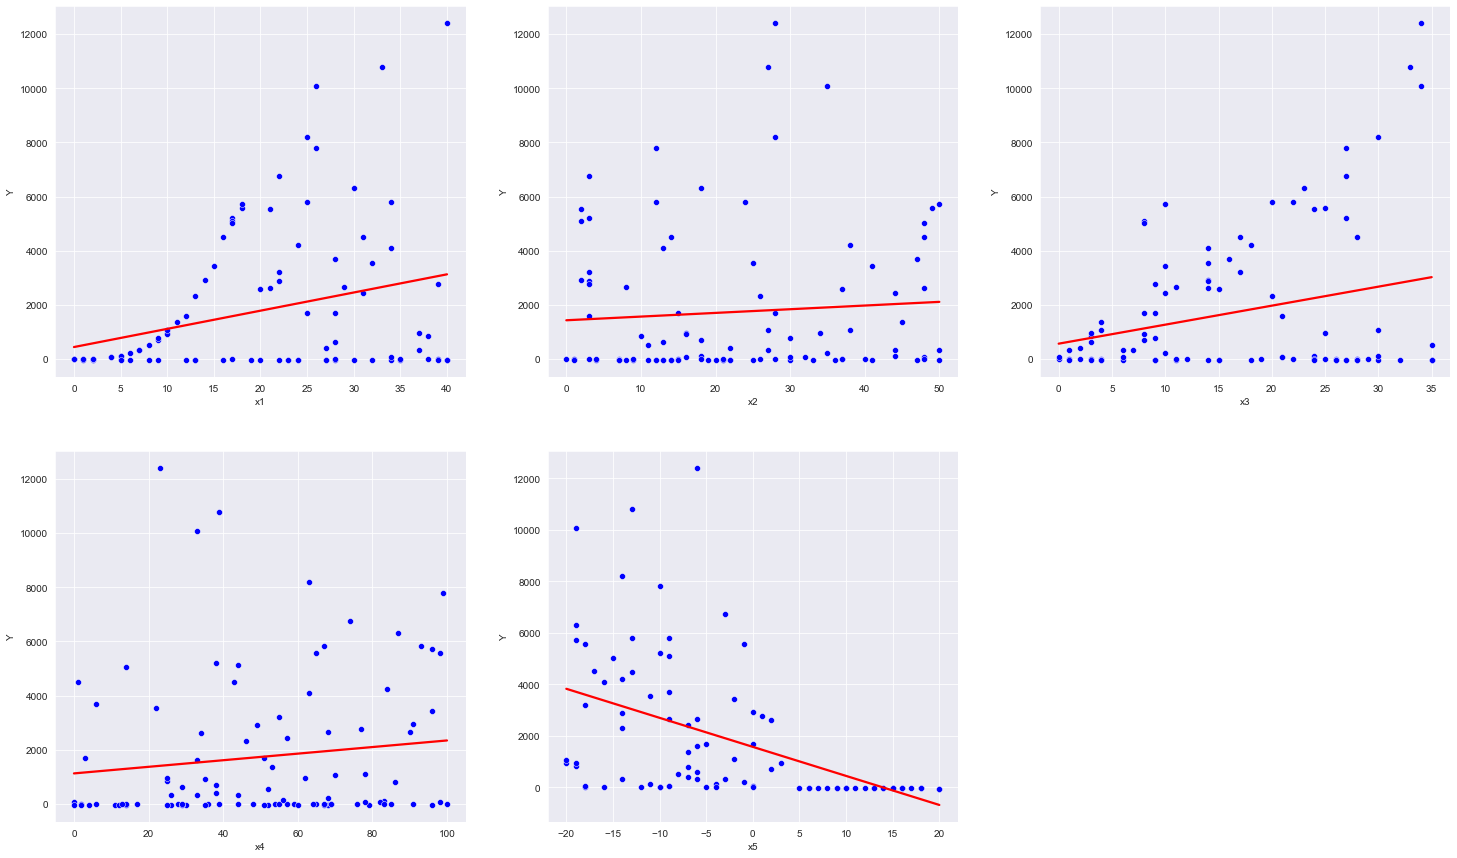

In [226]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 3, 1)
sns.scatterplot(x=dataset['x1'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x1'], y=cv_predictions, color='r', scatter=False, ci=False)

plt.subplot(2, 3, 2)
sns.scatterplot(x=dataset['x2'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x2'], y=cv_predictions, color='r', scatter=False, ci=False)

plt.subplot(2, 3, 3)
sns.scatterplot(x=dataset['x3'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x3'], y=cv_predictions, color='r', scatter=False, ci=False)

plt.subplot(2, 3, 4)
sns.scatterplot(x=dataset['x4'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x4'], y=cv_predictions, color='r', scatter=False, ci=False)

plt.subplot(2, 3, 5)
sns.scatterplot(x=dataset['x5'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x5'], y=cv_predictions, color='r', scatter=False, ci=False)

After applying the linear regression for each predictor, I can see that the error rate is quite high. Which means that the model is not accurate.

In [227]:
lin_reg_errors = pd.DataFrame()

for i in predictors:
    lin_pred, cv_predictions, rmse_score = linear_regression(x=dataset[predictors], y=dataset['Y'],
                                                             selected_predictors=[i], cv=10)
    lin_reg_errors.loc['rmse', i] = np.mean(rmse_score)

lin_reg_errors.sort_values(by='rmse', axis=1, ascending=True)

,x5,x1,x3,x4,x2
rmse,2210.442221,2510.762374,2520.125624,2559.64427,2601.730101


Best performing predictor is x5 which has the root-mean-squared error of 2210.

In [228]:
pd.DataFrame(data=min(lin_reg_errors.min(axis=1)), columns=lin_reg_errors.idxmin(axis=1), index=['rmse'])

,x5
rmse,2210.442221


In [229]:
lin_reg_error = pd.DataFrame(data=min(lin_reg_errors.min(axis=1)), columns=lin_reg_errors.idxmin(axis=1), index=['rmse']).iat[0, 0]
lin_reg_predictor = pd.DataFrame(data=min(lin_reg_errors.min(axis=1)), columns=lin_reg_errors.idxmin(axis=1), index=['rmse']).columns[0]

### Multiple Linear Regression

In [230]:
def all_combinations(pred, n=2):
    comb = []
    for k in range(n, len(pred) + 1):
        comb.extend(list(combinations(pred, k)))
    return list(map(list, comb))

In [231]:
predictor_combinations = all_combinations(pred=predictors)

In [232]:
def multiple_linear_regression(x, y, selected_predictors=None):
    cval_score = np.sqrt(cross_val_score(estimator=LinearRegression(), X=x[selected_predictors], y=y, cv=10,
                                       scoring=make_scorer(mean_squared_error)))
    cval_pred = cross_val_predict(estimator=LinearRegression(), X=x[selected_predictors], y=y, cv=10)
    lr = LinearRegression()
    lr.fit(x, y)
    y_pred = lr.predict(test_data[predictors])

    return y_pred, cval_pred, cval_score

I applied multiple linear regression to every possible combination of predictors.

In [233]:
multi_lin_reg_errors = pd.DataFrame()

for i in predictor_combinations:
    lin_pred, cv_predictions, rmse_score = multiple_linear_regression(x=dataset[predictors], y=dataset['Y'],
                                                                      selected_predictors=i)
    multi_lin_reg_errors.loc[f'rmse', f'{i}'] = np.mean(rmse_score)

multi_lin_reg_errors.sort_values('rmse', axis=1, ascending=True)

,"['x1', 'x3', 'x5']","['x1', 'x3', 'x4', 'x5']","['x1', 'x2', 'x3', 'x5']","['x1', 'x2', 'x3', 'x4', 'x5']","['x3', 'x5']","['x3', 'x4', 'x5']","['x2', 'x3', 'x5']","['x1', 'x4', 'x5']","['x1', 'x5']","['x2', 'x3', 'x4', 'x5']",...,"['x1', 'x3', 'x4']","['x1', 'x2', 'x3', 'x4']","['x1', 'x2', 'x3']","['x1', 'x4']","['x1', 'x2', 'x4']","['x1', 'x2']","['x3', 'x4']","['x2', 'x3']","['x2', 'x3', 'x4']","['x2', 'x4']"
rmse,1910.106249,1924.038679,1924.292535,1934.214945,2076.000607,2090.922246,2099.966432,2102.036575,2104.561299,2115.12053,...,2434.899699,2440.186802,2441.518317,2486.777365,2490.305314,2521.067141,2524.755855,2547.721339,2549.841254,2585.360337


The best performing predictor set was [x1, x3, x5] with the root-mean-squared error of 1910.
I can see that the multiple linear regression gives better result than the linear regression but the model is still not too accurate.

In [234]:
pd.DataFrame(data=min(multi_lin_reg_errors.min(axis=1)), columns=multi_lin_reg_errors.idxmin(axis=1), index=['rmse'])

,"['x1', 'x3', 'x5']"
rmse,1910.106249


In [235]:
multi_lin_reg_error = pd.DataFrame(data=min(multi_lin_reg_errors.min(axis=1)), columns=multi_lin_reg_errors.idxmin(axis=1),
             index=['rmse']).iat[0, 0]
multi_lin_reg_predictor = pd.DataFrame(data=min(multi_lin_reg_errors.min(axis=1)), columns=multi_lin_reg_errors.idxmin(axis=1),
             index=['rmse']).columns[0]

#### K-Nearest Neighbors Regression (KNN)

In [236]:
def k_nearest_neighbors(x, y, n_neighbors, selected_predictors=None):
    cv_score = np.sqrt(
        cross_val_score(estimator=KNeighborsRegressor(n_neighbors=n_neighbors), X=x[selected_predictors], y=y, cv=10,
                        scoring=make_scorer(mean_squared_error)))
    cv_pred = cross_val_predict(estimator=KNeighborsRegressor(n_neighbors=n_neighbors), X=x[selected_predictors], y=y,
                                cv=10)
    knn = KNeighborsRegressor()
    knn.fit(x, y)
    y_pred = knn.predict(test_data[predictors])

    return y_pred, cv_pred, cv_score

I applied K-Nearest Neighbors Regression to every possible combination of predictors with different k-neighbor values.
I see that the results are much better than the multiple linear regression and linear regression.

In [237]:
knn_errors = pd.DataFrame()

for i in predictor_combinations:
    for j in range(1, 6):
        knn_pred, cv_predictions, rmse_score = k_nearest_neighbors(x=dataset[predictors], y=dataset['Y'], n_neighbors=j,
                                                                   selected_predictors=i)
        knn_errors.loc[f'k={j}', f'{i}'] = np.mean(rmse_score)

knn_errors.sort_values('k=1', axis=1)

,"['x1', 'x3', 'x5']","['x1', 'x2', 'x3', 'x5']","['x1', 'x3', 'x4', 'x5']","['x1', 'x2', 'x3', 'x4', 'x5']","['x1', 'x4', 'x5']","['x1', 'x2', 'x3']","['x1', 'x5']","['x1', 'x2', 'x3', 'x4']","['x1', 'x2', 'x5']","['x1', 'x3', 'x4']",...,"['x1', 'x3']","['x2', 'x3', 'x4']","['x2', 'x4', 'x5']","['x1', 'x4']","['x3', 'x4']","['x4', 'x5']","['x2', 'x3']","['x1', 'x2', 'x4']","['x2', 'x5']","['x2', 'x4']"
k=1,929.987370,1432.408637,1647.262552,1767.443480,1965.644913,2005.364508,2037.116675,2075.707816,2146.226129,2467.353415,...,2905.957419,2985.087873,2988.400730,3005.388695,3027.913465,3081.655172,3177.046639,3355.637433,3512.934278,3646.598452
k=2,994.186611,1140.510381,1693.624024,1682.114597,1995.625908,1794.330004,1758.875587,2236.852906,1941.674118,2373.158479,...,2350.905494,2949.343647,2372.833913,2812.266440,2956.863613,2525.489811,2846.819946,2789.891843,2823.982269,2947.599812
k=3,993.033317,1180.900049,1577.975541,1665.763135,2096.165784,2193.420573,1597.162447,2061.100545,1886.646430,2470.091585,...,2302.120998,2742.956567,2533.528968,2716.955055,2865.168712,2444.421012,2829.599356,2515.984168,2691.648883,2945.427627
k=4,987.560309,1263.017896,1538.330660,1754.154319,2128.848847,2120.230179,1585.860020,2115.319319,1885.277637,2454.306093,...,2144.728081,2751.263377,2576.133503,2682.530278,2719.133982,2404.992893,2780.944218,2566.458134,2543.707707,2948.854939
k=5,1054.094389,1293.328271,1571.906308,1815.716240,2203.664295,2207.379111,1572.929634,2188.324953,1884.304601,2441.053900,...,2145.875433,2617.927090,2554.141560,2539.694792,2737.790135,2339.391140,2691.074349,2556.553580,2515.642968,2887.464097


The best performing predictor set was [x1, x3, x5] (k=1) with the root-mean-squared error of 929.

In [238]:
lowest_knn_error = pd.DataFrame(data=min(knn_errors.min(axis=1)), columns=knn_errors.idxmin(axis=1), index=['rmse'])
lowest_knn_error.index.name = knn_errors.index[knn_errors[knn_errors.idxmin(axis=1)[0]] == min(knn_errors.min(axis=1))].values[0]
pd.DataFrame(lowest_knn_error.iloc[:, 0])

,"['x1', 'x3', 'x5']"
k=1,
rmse,929.98737


In [239]:
knn_error = pd.DataFrame(lowest_knn_error.iloc[:, 0]).iat[0, 0]
knn_predictor = pd.DataFrame(lowest_knn_error.iloc[:, 0]).columns[0]

#### Decision Tree Regression

Decision Tree normally uses greedy algorithm to find the best split but this makes the result different every time. I want the result be the same(consistent) every time. That is why I gave random_state the value 0.

In [240]:
def decision_tree_regression(x, y, max_depth, selected_predictors=None):
    cv_score = np.sqrt(
        cross_val_score(estimator=DecisionTreeRegressor(random_state=0, max_depth=max_depth), X=x[selected_predictors],
                        y=y, cv=10, scoring=make_scorer(mean_squared_error)))
    cv_pred = cross_val_predict(estimator=DecisionTreeRegressor(random_state=0, max_depth=max_depth),
                                X=x[selected_predictors], y=y, cv=10)
    dt = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    dt.fit(x, y)
    y_pred = dt.predict(test_data[predictors])

    return y_pred, cv_pred, cv_score

I applied Decision Tree Regression to every possible combination of predictors with different max tree depth values.
I see that the results are even better than knn regression.

In [241]:
dec_tree_errors = pd.DataFrame()
dec_tree_predictions = dict()

for i in predictor_combinations:
    for j in range(1, 6):
        dt_pred, cv_predictions, rmse_score = decision_tree_regression(x=dataset[predictors], y=dataset['Y'],
                                                                       max_depth=j, selected_predictors=i)
        dec_tree_errors.loc[f'depth={j}', f'{i}'] = np.mean(rmse_score)
        dec_tree_predictions[np.mean(rmse_score)] = dt_pred

dec_tree_errors.sort_values('depth=5', axis=1, ascending=True)

,"['x1', 'x3', 'x5']","['x1', 'x3', 'x4', 'x5']","['x1', 'x2', 'x3', 'x5']","['x1', 'x2', 'x3', 'x4', 'x5']","['x1', 'x2', 'x4', 'x5']","['x1', 'x5']","['x1', 'x4', 'x5']","['x1', 'x2', 'x5']","['x2', 'x3', 'x4', 'x5']","['x2', 'x3', 'x5']",...,"['x4', 'x5']","['x2', 'x4', 'x5']","['x1', 'x3', 'x4']","['x1', 'x2', 'x3', 'x4']","['x2', 'x5']","['x2', 'x4']","['x1', 'x2', 'x4']","['x2', 'x3', 'x4']","['x3', 'x4']","['x1', 'x4']"
depth=1,2425.438542,2425.438542,2425.438542,2425.438542,2425.438542,2425.438542,2425.438542,2425.438542,2425.438542,2425.438542,...,2425.438542,2425.438542,2374.505223,2374.505223,2425.438542,2642.372451,2374.505223,2725.648895,2725.648895,2374.505223
depth=2,1924.648145,1924.648145,1924.648145,1924.648145,1924.648145,1924.648145,1924.648145,1924.648145,2287.371145,2287.371145,...,2410.292986,2437.391233,2522.818436,2522.818436,2292.366013,2870.713761,2528.941507,2974.301987,2774.685629,2478.370203
depth=3,1442.056053,1492.068856,1500.830847,1500.830847,1819.359109,1762.765503,1810.851934,1819.359109,2095.357232,2034.071918,...,2270.336141,2520.888196,2730.165477,2679.522808,2623.457638,2622.025898,2559.523993,2995.478742,2833.747439,2824.080419
depth=4,935.752065,1056.742746,1101.001706,1060.890733,1901.962907,1863.437145,1859.363845,1872.777812,2190.840832,2141.329060,...,2591.097099,2651.256536,2788.065740,2831.454767,2714.976787,2640.000243,2555.448689,2840.754439,2973.423569,2989.024467
depth=5,805.321956,946.065834,972.683444,1031.164213,1796.396154,1811.589229,1827.755478,1903.795579,2158.729972,2206.002758,...,2844.635758,2862.676408,2907.905770,2939.428761,2944.622385,2962.325838,2965.899870,3004.393100,3063.904615,3119.855334


The best performing predictor set was [x1, x2] (depth=5) with the root-mean-squared error of 805.

In [242]:
lowest_dec_tree_error = pd.DataFrame(data=min(dec_tree_errors.min(axis=1)), columns=dec_tree_errors.idxmin(axis=1),
                                     index=['rmse'])
lowest_dec_tree_error.index.name = dec_tree_errors.index[dec_tree_errors[dec_tree_errors.idxmin(axis=1)[-1]] == min(dec_tree_errors.min(axis=1))].values[0]
pd.DataFrame(lowest_dec_tree_error.iloc[:, 0])

,"['x1', 'x2']"
depth=5,
rmse,805.321956


In [243]:
dec_tree_error = pd.DataFrame(lowest_dec_tree_error.iloc[:, 0]).iat[0, 0]
dec_tree_predictor = pd.DataFrame(lowest_dec_tree_error.iloc[:, 0]).columns[0]

#### Random Forest Regression

I see that the Tree Regression gives a good result. That is why I have decided to apply Random Forest Regression as well.

In [244]:
def random_forest_regression(x, y, max_depth, selected_predictors=None):
    cv_score = np.sqrt(
        cross_val_score(estimator=RandomForestRegressor(random_state=0, max_depth=max_depth), X=x[selected_predictors],
                        y=y, cv=10, scoring=make_scorer(mean_squared_error)))
    cv_pred = cross_val_predict(estimator=RandomForestRegressor(random_state=0, max_depth=max_depth),
                                X=x[selected_predictors], y=y, cv=10)
    rf = RandomForestRegressor(random_state=0, max_depth=max_depth)
    rf.fit(x, y)
    y_pred = rf.predict(test_data[predictors])

    return y_pred, cv_pred, cv_score

I applied Random Forest Regression to every possible combination of predictors with different max tree depth values.

In [245]:
rf_errors = pd.DataFrame()
rf_predictions = dict()

for i in predictor_combinations:
    for j in range(1, 6):
        rf_pred, cv_predictions, rmse_score = random_forest_regression(x=dataset[predictors], y=dataset['Y'], max_depth=j, selected_predictors=i)
        rf_errors.loc[f'depth={j}', f'{i}'] = np.mean(rmse_score)
        rf_predictions[np.mean(rmse_score)] = rf_pred

rf_errors.sort_values('depth=5', axis=1)

,"['x1', 'x3', 'x5']","['x1', 'x2', 'x3', 'x5']","['x1', 'x3', 'x4', 'x5']","['x1', 'x2', 'x3', 'x4', 'x5']","['x1', 'x5']","['x1', 'x4', 'x5']","['x1', 'x2', 'x5']","['x1', 'x2', 'x4', 'x5']","['x2', 'x3', 'x5']","['x3', 'x5']",...,"['x1', 'x2']","['x2', 'x3']","['x4', 'x5']","['x1', 'x2', 'x4']","['x2', 'x4', 'x5']","['x2', 'x3', 'x4']","['x1', 'x4']","['x2', 'x5']","['x3', 'x4']","['x2', 'x4']"
depth=1,2316.474208,2316.812572,2323.193094,2323.554578,2276.879979,2284.036463,2277.146034,2284.335955,2320.807535,2320.427023,...,2423.291937,2617.580988,2294.488915,2428.853799,2294.765803,2644.848179,2429.257163,2289.959066,2640.200682,2619.798783
depth=2,1877.555407,1904.847616,1893.184641,1909.471107,1798.734597,1814.889011,1821.509005,1830.712346,2118.782429,2100.979390,...,2362.091496,2520.561946,2302.710162,2395.403158,2327.029043,2553.961430,2423.769275,2311.552197,2526.176679,2637.597016
depth=3,1406.409434,1449.626237,1428.527678,1476.041641,1707.953383,1729.875127,1743.971509,1757.408721,2040.207997,2020.177015,...,2367.180542,2430.359676,2324.490554,2445.035377,2389.428510,2494.484478,2494.502883,2382.716054,2527.699424,2644.647388
depth=4,1031.977188,1109.278233,1120.216733,1171.013150,1649.042437,1698.258572,1722.536902,1736.580843,2062.045586,2050.035219,...,2323.403453,2420.846565,2385.733698,2445.917237,2444.199678,2497.417093,2509.142907,2469.121966,2554.592009,2702.879601
depth=5,921.403304,1013.819096,1020.549475,1070.002024,1599.016882,1693.449189,1702.087204,1750.544297,2055.829421,2073.797911,...,2323.160734,2385.499455,2417.080921,2464.984767,2479.997435,2507.142490,2513.284550,2558.705651,2591.116514,2769.199230


In [246]:
lowest_rf_error = pd.DataFrame(data=min(rf_errors.min(axis=1)), columns=rf_errors.idxmin(axis=1), index=['rmse'])
lowest_rf_error.index.name = rf_errors.index[rf_errors[rf_errors.idxmin(axis=1)[-1]] == min(rf_errors.min(axis=1))].values[0]
pd.DataFrame(lowest_rf_error.iloc[:, 0])

,"['x1', 'x5']"
depth=5,
rmse,921.403304


In [247]:
rf_error = pd.DataFrame(lowest_rf_error.iloc[:, 0]).iat[0, 0]
rf_predictor = pd.DataFrame(lowest_rf_error.iloc[:, 0]).columns[0]

In [248]:
results = pd.DataFrame(columns=['predictors', 'rmse'],
                       index=['linear regression', 'multiple linear regression', 'knn', 'decision tree',
                              'random forest'])

In [249]:
results.loc['knn', 'rmse'] = knn_error
results.loc['knn', 'predictors'] = knn_predictor
results.loc['decision tree', 'rmse'] = dec_tree_error
results.loc['decision tree', 'predictors'] = dec_tree_predictor
results.loc['random forest', 'rmse'] = rf_error
results.loc['random forest', 'predictors'] = rf_predictor
results.loc['multiple linear regression', 'rmse'] = multi_lin_reg_error
results.loc['multiple linear regression', 'predictors'] = multi_lin_reg_predictor
results.loc['linear regression', 'rmse'] = lin_reg_error
results.loc['linear regression', 'predictors'] = lin_reg_predictor

The final results shows that the best performing algorithm is Decision Tree with [x1, x2] predictors.

In [250]:
results.sort_values('rmse', axis=0)

,predictors,rmse
decision tree,"['x1', 'x2']",805.321956
random forest,"['x1', 'x5']",921.403304
knn,"['x1', 'x3', 'x5']",929.98737
multiple linear regression,"['x1', 'x3', 'x5']",1910.106249
linear regression,x5,2210.442221


Decision Tree gives relatively the best results so, I used this model to predict the missing values.
These are the final results:

In [307]:
test_data['Y'] = dec_tree_predictions[dec_tree_error]
test_data

,x1,x2,x3,x4,x5,Y
100,8,46,30,32,5,-12.000000
101,10,23,16,27,13,-24.000000
102,6,9,28,76,-20,531.000000
103,11,31,3,46,-11,1118.000000
104,12,27,0,98,20,-42.000000
105,1,5,29,100,-3,2.888889
106,2,1,1,53,-11,2.888889
107,35,1,0,48,-11,269.000000
108,38,47,29,36,4,932.000000
109,16,25,3,31,18,-35.142857


In [310]:
final_dataset = pd.concat([dataset, test_data], ignore_index=True)
final_dataset['x6'] = final_dataset['x1']
final_dataset = final_dataset[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'Y']]
final_dataset.to_csv('results.csv', index=False)